# Sharp Optical Flow

In [4]:
import cv2 as cv
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
import pims, tifffile
from skimage.filters import scharr_h, scharr_v, gaussian
from lib.optical_flow import OpticalFlowClient

#serial parallelization tools
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

#import tkinter for simple gui
from tkinter import filedialog, Tk, Canvas, PhotoImage 
from PIL import ImageTk,Image 

#automate the boring stuff
import time, os, sys, re
beep = lambda x: os.system("echo -n '\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
print('notebook is at: ' + nb_dir)

%load_ext autoreload
%autoreload 2

notebook is at: /Users/timothytyree/Documents/GitHub/optical_flow/notebooks
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# step 0: find the files you want interactively

In [8]:
import os
from tkinter import filedialog, Tk
def search_for_file (currdir = os.getcwd()):
	'''#make functions for save file name, input cell frames, and input cell trajectories'''
	#TODO: eventually make this ^take cell trajectories or cell positions
	root = Tk()
	tempdir = filedialog.askopenfilename(parent=root, 
										 initialdir=currdir, 
										 title="Please select a file")#, 
										 # filetypes = (("all files","*.*")))
	root.destroy()
	if len(tempdir) > 0:
		print ("File: %s" % tempdir)
	return tempdir

def find_files(filename, search_path):
	'''recursively search everywhere inside of search_path and return all files matching filename.'''
	result = []
	for root, dir, files in os.walk(search_path):
		if filename in files:
			result.append(os.path.join(root, filename))
	return result

def find_file(**kwargs):
	'''recursively search everywhere inside of search_path for filename.  Returns the first found.  This could be optimized with a greedy algorithm.'''
	return find_files(**kwargs)[0]

In [9]:
cluster_dir = search_for_file('cluster_122019_pos1_middle_cubic_spline.csv')
print(cluster_dir)

File: /Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/experiment_with_DTT/4X/122019/122019_pos1/cluster_122019_pos1_middle_cubic_spline.csv
/Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/experiment_with_DTT/4X/122019/122019_pos1/cluster_122019_pos1_middle_cubic_spline.csv


### step 0.1 prepare a trajectory for the origin of cell motion

### option a: find a .csv with a cluster trajectory in it that you already made

In [9]:
cluster_dir = search_for_file('cluster_122019_pos1_middle_cubic_spline.csv')
print(cluster_dir)

File: /Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/experiment_with_DTT/4X/122019/122019_pos1/cluster_122019_pos1_middle_cubic_spline.csv
/Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/experiment_with_DTT/4X/122019/122019_pos1/cluster_122019_pos1_middle_cubic_spline.csv


### option b: set cluster trajectory to a constant value

In [123]:
print('please select your microscopy .tif file.')
dic_dir = search_for_frame_path(os.getcwd())

please select your microscopy .tif file.


In [27]:
frames= pims.TiffStack(dic_dir)
print(frames)
trialnum = input('trialnum =')

<Frames>
Source: /Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/Richa's High Time Resolution Experiment/Data/08042020 c2P1_20X_C1.tif
Length: 651 frames
Frame Shape: (512, 512)
Pixel Datatype: uint16


In [36]:
print('please enter the xy pixel coordinates of the cluster origin/center.')
x = input('x = ')
y = input('y = ')
number_of_frames = len(frames)
f = np.array(sorted(range(number_of_frames)))
dct = {'frame':f,
      'x':eval(x) + 0.*f,
      'y':eval(y) + 0.*f}
df = pd.DataFrame(dct)
df.head()

please enter the xy pixel coordinates of the cluster origin/center.
x = 290
y = 270


,frames,x,y
0,0,290.0,270.0
1,1,290.0,270.0
2,2,290.0,270.0
3,3,290.0,270.0
4,4,290.0,270.0


In [46]:
try:
    os.mkdir(trialnum)
except Exception as e:
    print(e)

[Errno 17] File exists: '08042020 c2P2'


In [47]:
save_folder = '/'.join(dic_dir.split('/')[:-1])
os.chdir(save_folder)
save_folder = save_folder+'/'+trialnum
os.chdir(save_folder)

In [49]:
cluster_dir = 'cluster.csv'
df.to_csv(cluster_dir, index=False)

### option c: get cluster trajectory by spline interpolation of manual measurements
manual measurments may be taken in ImageJ

In [276]:
#IF a cluster trajectory or needle tip trajectory already exists 
# as a dense timeseries stored in a .csv, carry on to step 2.

print('please select a \'.xlsx\' of the cluster trajectories.')
input_dir = search_for_frame_path()


please select a '.xlsx' of the cluster trajectories.
Frames: /Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/PDE_experiment_new/091019/cluster_pos_4.xlsx


In [209]:
#for pde1 experiment
# input_dir = '/Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/PDE_experiment_new/091019/cluster_pos_4.xlsx'

/Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/Python/data/data_for_dispersal_from_needle/Repellent Effect/103119


In [286]:
# load 
data_dir = os.sep.join(input_dir.split(os.sep)[:-1])
os.chdir(data_dir)
excel_dir = input_dir.split(os.sep)[-1]
sheet_name = None #"top_right"
if sheet_name is not None:
    save_dir = make_save_dir(excel_dir,sheet_name)
    df = pd.read_excel(excel_dir, sheet_name=sheet_name)
else:
    save_dir = f'{excel_dir[:-5]}.csv'
    df = pd.read_excel(excel_dir)
print(save_dir)

cluster_pos_4.csv


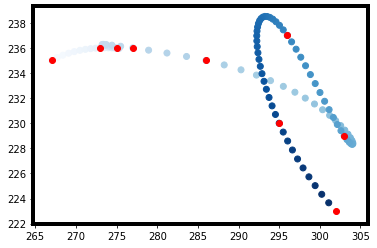

In [288]:
of = OpticalFlowClient()
cf = of.interpolate_trajectory(df)
plt.scatter(x=cf.x, y=cf.y, c=cf.frame, cmap='Blues')
plt.scatter(x=df.x, y=df.y, c='r')

In [289]:
cf.describe().T

,count,mean,std,min,25%,50%,75%,max
frame,106.0,53.500000,30.743563,1.000000,27.250000,53.500000,79.750000,106.000000
x,106.0,289.602175,11.658229,267.000000,275.237492,293.334617,298.795799,304.062007
y,106.0,233.601496,3.651044,223.660608,230.646361,235.242726,236.078035,238.507803


In [290]:
cf.to_csv(save_dir, index=False)
#assumption: xlsx file starts with the first frame and ends with the last frame.
#nota bene: the plot of the trajectory should be reasonably smooth if the cluster moves.

In [291]:
df_dir = save_dir

In [292]:
cluster_dir = save_dir

# step 1 tune a custom optical flow method 
- Here, I developed a method that doesn't use the blurred mask of cell location to get sharp highlights of cell motion.
  - Hypothesis: this will make the spatially averaged time traces too messy to be easily interpreted.

In [97]:
#for 051719Pos4
workspace_dir = '/Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/Python/data/data_for_dispersing_051719Pos4/optical_flow_results/'
os.chdir(workspace_dir)
flow_dir = 'flow_radial_051719_pos4_sharp.tiff'
# flow_dir = 'flow_radial_051719_pos4.tiff'
dic_dir  = '../frames051719Pos4 copy.tiff'
fret_dir = '../chnl1_051719Pos4 copy.tiff'
# path = search_for_frame_path(workspace_dir)
df_dir = '../centroid copy.csv'
dt = 0.5

In [98]:
of = OpticalFlowClient()
dic_frames = of.load_tiff_stack(dic_dir)
flow_frames = of.load_tiff_stack(flow_dir)
fret_frames = of.load_tiff_stack(fret_dir)
assert(len(dic_frames)==len(flow_frames)+1)
assert(len(flow_frames)+1==len(fret_frames))

In [99]:
df = pd.read_csv(df_dir).head(len(flow_frames))
print(df.frame.size)

353


In [100]:
onset_frame = 116
frm = 180
tme = dt*(frm-onset_frame)
print(tme)

32.0


In [110]:
flow_in = flow_frames[frm-1][...,0]
flow_out = flow_frames[frm-1][...,1]
background_frame = dic_frames[frm]#
position = tuple(np.around(df.loc[frm][['x','y']].astype('uint8').values))

In [129]:
position = (350,113)
# of.highlight?

Frame([[[ 84.        ,  84.        ,  84.        ],
        [134.        , 134.        , 134.        ],
        [141.        , 141.        , 141.        ],
        ...,
        [ 60.        ,  60.        ,  60.        ],
        [ 55.        ,  55.        ,  55.        ],
        [ 52.        ,  52.        ,  52.        ]],

       [[134.        , 134.        , 134.        ],
        [170.        , 148.37881851, 148.37881851],
        [171.        , 171.        , 171.        ],
        ...,
        [ 65.        ,  65.        ,  65.        ],
        [ 13.35000992,  54.        ,  54.        ],
        [ 29.        ,  29.        ,  29.        ]],

       [[157.        , 157.        , 157.        ],
        [176.        , 176.        , 176.        ],
        [164.        , 164.        , 164.        ],
        ...,
        [ 41.21845245,  82.        ,  82.        ],
        [  7.65874863,  49.        ,  49.        ],
        [ 11.        ,  11.        ,  11.        ]],

       ...,

       [[150.        , 150.        , 150.        ],
        [153.        , 153.        , 153.        ],
        [158.        , 158.        , 158.        ],
        ...,
        [133.        ,  58.34776306,  58.34776306],
        [112.        ,  37.11566162,  37.11566162],
        [118.        , 118.        , 118.        ]],

       [[152.        , 152.        , 152.        ],
        [149.        , 149.        , 149.        ],
        [150.        , 150.        , 150.        ],
        ...,
        [104.        ,  29.40078735,  29.40078735],
        [ 82.        ,   7.18643951,   7.18643951],
        [ 88.        ,  88.        ,  88.        ]],

       [[152.        , 152.        , 152.        ],
        [154.        , 154.        , 154.        ],
        [160.        , 160.        , 160.        ],
        ...,
        [104.        , 104.        , 104.        ],
        [ 90.        ,  90.        ,  90.        ],
        [ 85.        ,  85.        ,  85.        ]]])
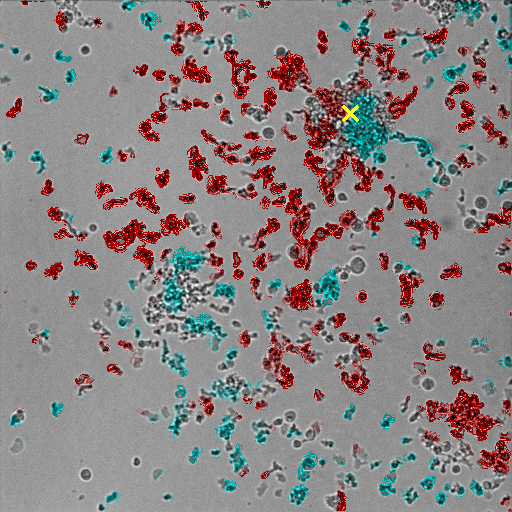

In [130]:
of.hue_scale_red = 100
of.hue_scale_blue = 100
retval = of.highlight(position=position, flow_in=flow_in, flow_out=flow_out, background_frame=background_frame)
retval

In [131]:
from mark_images import *

True

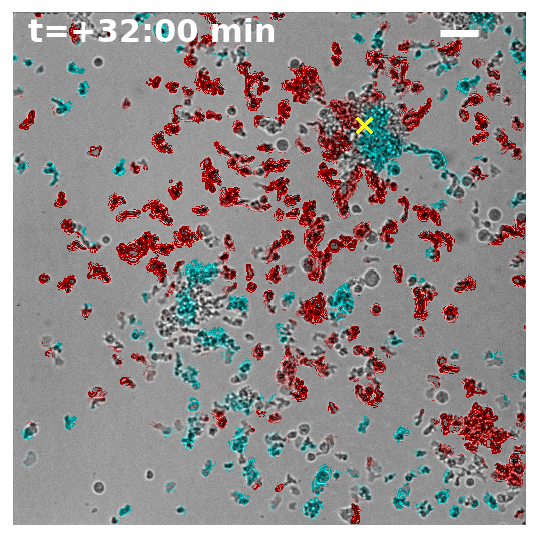

In [132]:
# make_input_image(self, img, message = None, time_stamp = None, save_file_name = None)
# os.chdir(nb_dir+'/../data/the_big_busts')
# file_name_pic = 'pic_120519_pos7_prebusted.png'
time_stamp = 't=+32:00 min'
# save_file_name = file_name_pic.replace('.png', '_formatted.png')
# trialnum = '120519_pos4'
# img = pims.image_reader.imread(file_name_pic)
# img = pims.frame.Frame(img)
save_file_name = f'test_sharp.png'
img = pims.frame.Frame(retval)
img = pims.normalize(img)
make_input_image(img, save_file_name, message=None, time_stamp=time_stamp, y_start = 505,lamda = 1.33, uml=50, width = 4)




In [76]:
img = retval




/Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/Python/data/data_for_dispersing_051719Pos4/optical_flow_results


Frame([[[0.32941176, 0.32941176, 0.32941176],
        [0.5254902 , 0.5254902 , 0.5254902 ],
        [0.55294118, 0.55294118, 0.55294118],
        ...,
        [0.23529412, 0.23529412, 0.23529412],
        [0.21568627, 0.21568627, 0.21568627],
        [0.20392157, 0.20392157, 0.20392157]],

       [[0.5254902 , 0.5254902 , 0.5254902 ],
        [0.66666667, 0.60731441, 0.60731441],
        [0.67058824, 0.67058824, 0.67058824],
        ...,
        [0.25490196, 0.25490196, 0.25490196],
        [0.06829415, 0.21176471, 0.21176471],
        [0.11372549, 0.11372549, 0.11372549]],

       [[0.61568627, 0.61568627, 0.61568627],
        [0.69019608, 0.69019608, 0.69019608],
        [0.64313725, 0.64313725, 0.64313725],
        ...,
        [0.17763376, 0.32156863, 0.32156863],
        [0.04624656, 0.19215686, 0.19215686],
        [0.04313725, 0.04313725, 0.04313725]],

       ...,

       [[0.58823529, 0.58823529, 0.58823529],
        [0.6       , 0.6       , 0.6       ],
        [0.61960784, 0.61960784, 0.61960784],
        ...,
        [0.52156863, 0.31664092, 0.31664092],
        [0.43921569, 0.23365084, 0.23365084],
        [0.4627451 , 0.4627451 , 0.4627451 ]],

       [[0.59607843, 0.59607843, 0.59607843],
        [0.58431373, 0.58431373, 0.58431373],
        [0.58823529, 0.58823529, 0.58823529],
        ...,
        [0.40784314, 0.20306099, 0.20306099],
        [0.32156863, 0.11619806, 0.11619806],
        [0.34509804, 0.34509804, 0.34509804]],

       [[0.59607843, 0.59607843, 0.59607843],
        [0.60392157, 0.60392157, 0.60392157],
        [0.62745098, 0.62745098, 0.62745098],
        ...,
        [0.40784314, 0.40784314, 0.40784314],
        [0.35294118, 0.35294118, 0.35294118],
        [0.33333333, 0.33333333, 0.33333333]]])
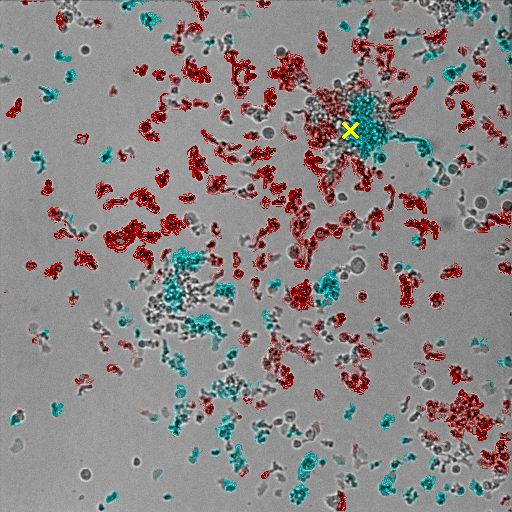

# step 2: use ^that routine to calculate flow for all frames and save as a .tif

In [59]:
#put all of step 1.b together into a function that takes two frames and returns the output texture
def calculate_output_texture(prv, nxt, raw_frame):
    #calculate DIS optical flow
    dis = cv.cv2.DISOpticalFlow_create(cv.cv2.DISOpticalFlow_PRESET_MEDIUM)
    img_flow = dis.calc(prv,nxt, flow=None)
    flow_x = img_flow[...,0]
    flow_right = flow_x.copy()
    flow_right[flow_right<=0] = 0
    flow_left = -flow_x.copy()
    flow_left[flow_left<=0] = 0
    
    #calculate cell area
    cell_area = gaussian(nxt+prv, sigma=3)
    threshold = 0.1
    cell_area[cell_area>threshold]  = 1
    cell_area[cell_area<=threshold] = 0
    
    #select flow only where there are cells
    flow_left_cells  = (cell_area*flow_left)
    flow_right_cells = (cell_area*flow_right)

    #compress data type (optional, but reccomended)
    flow_left_cells   = flow_left_cells.astype('float16')
    flow_right_cells  = flow_right_cells.astype('float16')
    cell_area_cells   = cell_area.astype('float16')
    raw_frame         = raw_frame.astype('float16')
    output_texture    = np.stack([flow_left_cells, flow_right_cells, cell_area_cells, raw_frame], axis=-1)
    return output_texture

In [60]:
#(optional) reload raw DIC frames
@pims.pipeline
def gray(image):
    return np.uint8(image[:, :, 0])  # Take just the red channel
frames = pims.TiffStack_libtiff(data_file_name)

In [61]:
#(optional) detect edges again
edges = preprocess(frames, thresh = 90)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  44 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done 203 out of 203 | elapsed:    8.0s finished


8.0 seconds elapsed taking scharr filtration.


the output has shape (492, 1716, 4), and data type float16.
the max value of  left flow is 5.25 while the min value of  left flow is 0.00.
the max value of right flow is 3.41 while the min value of right flow is 0.00.


Frame([[[0.000e+00, 0.000e+00, 0.000e+00, 4.717e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 4.973e+04],
        [0.000e+00, 7.332e-03, 1.000e+00, 5.328e+04],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, 4.176e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 4.326e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 3.859e+04]],

       [[0.000e+00, 0.000e+00, 0.000e+00, 5.021e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 4.998e+04],
        [0.000e+00, 7.755e-03, 1.000e+00, 5.245e+04],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, 4.822e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 4.800e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 4.490e+04]],

       [[0.000e+00, 0.000e+00, 0.000e+00, 4.710e+04],
        [0.000e+00, 7.374e-03, 1.000e+00, 5.011e+04],
        [0.000e+00, 8.606e-03, 1.000e+00, 5.120e+04],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, 4.835e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 4.749e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 4.413e+04]],

       ...,

       [[7.715e-02, 0.000e+00, 1.000e+00, 3.197e+04],
        [7.684e-02, 0.000e+00, 1.000e+00, 2.827e+04],
        [7.629e-02, 0.000e+00, 1.000e+00, 3.773e+04],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, 4.067e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 4.240e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 4.266e+04]],

       [[7.758e-02, 0.000e+00, 1.000e+00, 2.970e+04],
        [7.733e-02, 0.000e+00, 1.000e+00, 2.816e+04],
        [7.690e-02, 0.000e+00, 1.000e+00, 3.981e+04],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, 4.227e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 4.208e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 4.106e+04]],

       [[7.776e-02, 0.000e+00, 1.000e+00, 3.293e+04],
        [7.758e-02, 0.000e+00, 1.000e+00, 2.760e+04],
        [7.721e-02, 0.000e+00, 1.000e+00, 3.667e+04],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, 4.221e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 4.282e+04],
        [0.000e+00, 0.000e+00, 0.000e+00, 4.205e+04]]], dtype=float16)
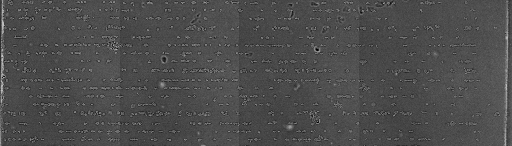

In [62]:
#test calculate_output_texture for example frame
frm = 31
raw_frame = frames[frm]
nxt = edges[frm]
prv = edges[frm-1]
output_texture = calculate_output_texture(prv=prv, nxt=nxt, raw_frame=raw_frame)

print(f"the output has shape {output_texture.shape}, and data type {output_texture.dtype}.")
print(f"the max value of  left flow is {np.max(output_texture[...,0]):.2f} while the min value of  left flow is {np.min(output_texture[...,0]):.2f}.")
print(f"the max value of right flow is {np.max(output_texture[...,1]):.2f} while the min value of right flow is {np.min(output_texture[...,1]):.2f}.")

pims.Frame(output_texture)

In [63]:
#define where to save
os.chdir(os.path.dirname(data_file_name))
save_file_name = os.path.basename(data_file_name).replace('.tif', '_output.tif')
save_params = {'append':'True', 'imagej':False, 'contiguous':True}
print(f"We're going to save in {save_file_name}, which is in {os.getcwd()}.") 

#remove the save file if it already exists
if os.path.exists(save_file_name):
    os.remove(save_file_name)

#loop over all frames (this could be parallelized)    
print('starting...')
start = time.time()
inputs = range(1,len(edges))
for frm in inputs:
    raw_frame = frames[frm]
    nxt = edges[frm]
    prv = edges[frm-1]
    output_texture = calculate_output_texture(prv=prv, nxt=nxt, raw_frame=raw_frame)
    tifffile.imsave(save_file_name, output_texture, output_texture.shape, **save_params)
end = time.time()
print('{} seconds elapsed calculating dense optical flow.'.format(np.around(end-start,1)))

We're going to save in pos1234_C0_output.tif, which is in /Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/Python/data/aravind's 1D data.
starting...
27.1 seconds elapsed calculating dense optical flow.


# step 3: visualize your work

## option a: mark an image - Fig. 1A

### version a (good!): Fig. 1A (does not make black spots from overlapping highlight)

In [ ]:
def make_fig1a(ttarget,frm_shift,load_file_name):
    navg  = 1
    dt = 0.5
    lamda = 1.33
    onset = 77#-navg
    tshift = ttarget/dt
    
    data_dir = f"{nb_dir}/../data/data_for_poster_child/optical_flow_output"
    # data_dir = f"{data_dir}/optical_flow_output/examples"
    trialnum = "poster_child"
    os.chdir(data_dir)
    output_dir = f"{nb_dir}/../fig/"
    file_name_flow = f'flow_radial_{trialnum}.tiff'
    traj_dir = f'needle_trajectory_{trialnum}.csv'
    traj_dir = "../poster_child_cluster_trajectory.csv"
    save_file_name = f'example_{trialnum}_t_{int(dt*tshift//1):+}_again.png'

    img = cv.imread(load_file_name)
    background_frame = img[...,0]
    flow   = pims.TiffStack_libtiff(file_name_flow)
    df     = pd.read_csv(traj_dir)
    # frames = pims.TiffStack_libtiff(dic_dir)


    # tshift = -7#150+75#128#96#85#(128+95)//2#
    # frm = int(116+tshift/dt)
    time_stamp = f't = {int(dt*tshift//1):+}:00 min'
    print(time_stamp)
    frm = tshift + onset+navg

    txt_avg = of.average_texture_list(flow[int(frm-navg-frm_shift):int(frm-frm_shift)])
    # background_frame = frames[frm]#f;#
    flow_in = txt_avg[...,0] #- txt_avg[...,1]
    flow_out = txt_avg[...,1] #- txt_avg[...,0]
    position = (int(df.loc[frm-frm_shift].x),int(df.loc[frm-frm_shift].y))
    of.hue_scale_blue = 512/8#2*
    of.hue_scale_red  = 512/8#2*
    out = of.highlight(tuple(position), flow_in, flow_out, background_frame=background_frame)

    # tshift = -20
    # dt = 0.5
    # save_file_name = img_dir[:-4]+f'_t_{int(dt*tshift//1):+}.png'
    # time_stamp = None#f't={30:+}:00 min'

    message = None
    make_input_image(out.astype('uint8'), save_file_name, message=message, time_stamp=time_stamp, y_start = 505, lamda=lamda, uml=50, width=4)
    print(f"save output in {save_file_name} which is found at")
    print(f"{os.getcwd()}")
    return True

ttarget= 65
frm_shift=-4
load_file_name = "examples/in1_c.png"
make_fig1a(ttarget,frm_shift,load_file_name)

### version b (bad!): get snapshots of flow - Fig. 5A (makes black spots from overlapping highlights)

In [273]:
traj_dir = f'needle_trajectory_{trialnum}.csv'
# traj_dir = f'cluster_{trialnum}.csv'

In [275]:
file_name_flow = f'flow_radial_{trialnum}.tiff'
flow   = pims.TiffStack_libtiff(file_name_flow)
frames = pims.TiffStack_libtiff(dic_dir)
# fret_frames = pims.TiffStack_libtiff(fret_dir)

df     = pd.read_csv(traj_dir)

True

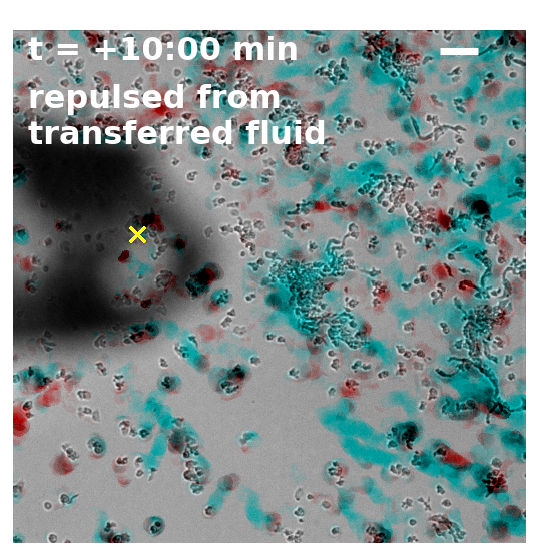

In [307]:
from mark_images import make_input_image

#frame outward flow
frm = 120
navg  = 90
dt = 1/3#0.5
onset = 0#37-navg
frm_shift=1
# tshift = -7#150+75#128#96#85#(128+95)//2#
# frm = int(116+tshift/dt)


tshift = frm - onset-navg
txt_avg = of.average_texture_list(flow[frm-navg-frm_shift:frm-frm_shift])
background_frame = frames[frm]#f;#
flow_in = txt_avg[...,0] #- txt_avg[...,1]
flow_out = txt_avg[...,1] #- txt_avg[...,0]
position = (int(df.loc[frm-frm_shift].x),int(df.loc[frm-frm_shift].y))
of.hue_scale_blue = 2*512
of.hue_scale_red  = 2*512
out = of.highlight(tuple(position), flow_in, flow_out, background_frame=background_frame)

# tshift = -20
# dt = 0.5
# save_file_name = img_dir[:-4]+f'_t_{int(dt*tshift//1):+}.png'
save_file_name = f'example_{trialnum}_t_{int(dt*tshift//1):+}.png'
time_stamp = f't = {int(dt*tshift//1):+}:00 min'
# time_stamp = None#f't={30:+}:00 min'

# message = '         before onset'
message = None#'\n\nrepulsed from\ntransferred fluid'

make_input_image(out.astype('uint8'), save_file_name, message=message, time_stamp=time_stamp, y_start = 505, lamda=lamda, uml=50, width=4)


## option b: assemble a movie of highlighted cell motion

### step 3.a: make a custom coloring routine for an example frame

In [66]:
#load frames
frames = pims.TiffStack_libtiff(save_file_name)

Frame([[50100., 52540., 53380., ..., 42660., 41660., 41630.],
       [49200., 49300., 53200., ..., 49180., 48640., 45340.],
       [46940., 51200., 51700., ..., 47700., 47000., 45100.],
       ...,
       [29460., 25730., 36830., ..., 40930., 40100., 42370.],
       [29120., 27170., 41470., ..., 41660., 44640., 42500.],
       [32860., 30860., 43800., ..., 42780., 44580., 42240.]],
      dtype=float16)
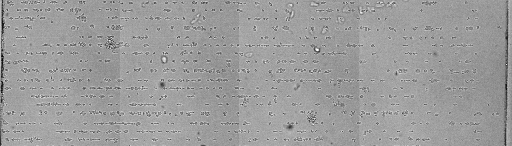

In [67]:
#view first raw DIC frame
frame = frames[10]
frame[...,3]

the max value of  left flow is 4.43359375 while the min value of  left flow is 0.0.
the max value of right flow is 2.90625 while the min value of right flow is 0.0.


Frame([[0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       ...,
       [0.084  , 0.0837 , 0.083  , ..., 0.     , 0.     , 0.     ],
       [0.0837 , 0.0829 , 0.08136, ..., 0.     , 0.     , 0.     ],
       [0.0835 , 0.0825 , 0.08057, ..., 0.     , 0.     , 0.     ]],
      dtype=float16)
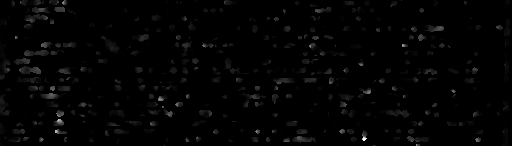

In [68]:
#view first left/right flow
print(f"the max value of  left flow is {np.max(frame[...,0])} while the min value of  left flow is {np.min(frame[...,0])}.")
print(f"the max value of right flow is {np.max(frame[...,1])} while the min value of right flow is {np.min(frame[...,1])}.")
frame[...,0]

In [51]:
#convert DIC frame to rbg image
raw_img = frame[...,3]
raw_img = pims.to_rgb(raw_img)
width, height, channel_number = raw_img.shape
print(f'this frame is {width} pixels wide, {height} pixels tall, and has {channel_number} colors.')

this frame is 492 pixels wide, 1716 pixels tall, and has 3 colors.


Frame([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 7.4453125 , 7.4453125 ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 7.45703125, 7.45703125],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 7.46875   , 7.46875   ],
        [0.        , 7.49609375, 7.49609375],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[8.3984375 , 0.        , 0.        ],
        [8.3671875 , 0.        , 0.        ],
        [8.296875  , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[8.3671875 , 0.        , 0.        ],
        [8.2890625 , 0.        , 0.        ],
        [8.1328125 , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[8.3515625 , 0.        , 0.        ],
        [8.25      , 0.        , 0.        ],
        [8.0546875 , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]]])
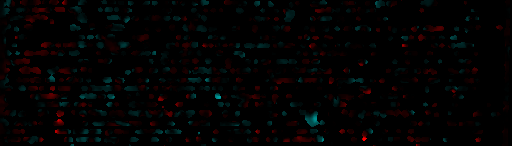

In [52]:
#define red/blue color scales
hue_scale_red  = 100
hue_scale_blue = 100

#make a red/blue filter to subtract from the raw image
left_flow    = frame[...,0]
right_flow   = frame[...,1]
filt = np.zeros([width,height,channel_number])
filt[...,0] = hue_scale_blue*left_flow#take away   red where flow is to the left
filt[...,1] = hue_scale_blue*left_flow#take away green where flow is to the left
filt[...,1] = hue_scale_red*right_flow#take away green where flow is to the right
filt[...,2] = hue_scale_red*right_flow#take away blue where flow is to the right
pims.Frame(filt)

the max value of right flow is 255 while the min value of right flow is 0.


Frame([[[178, 178, 178],
        [190, 190, 190],
        [194, 186, 186],
        ...,
        [141, 141, 141],
        [136, 136, 136],
        [136, 136, 136]],

       [[173, 173, 173],
        [174, 174, 174],
        [193, 185, 185],
        ...,
        [173, 173, 173],
        [171, 171, 171],
        [154, 154, 154]],

       [[162, 162, 162],
        [183, 175, 175],
        [186, 178, 178],
        ...,
        [166, 166, 166],
        [162, 162, 162],
        [153, 153, 153]],

       ...,

       [[ 66,  75,  75],
        [ 47,  56,  56],
        [103, 112, 112],
        ...,
        [132, 132, 132],
        [128, 128, 128],
        [139, 139, 139]],

       [[ 64,  73,  73],
        [ 55,  64,  64],
        [126, 135, 135],
        ...,
        [136, 136, 136],
        [151, 151, 151],
        [140, 140, 140]],

       [[ 83,  92,  92],
        [ 73,  82,  82],
        [138, 147, 147],
        ...,
        [141, 141, 141],
        [150, 150, 150],
        [139, 139, 139]]], dtype=uint8)
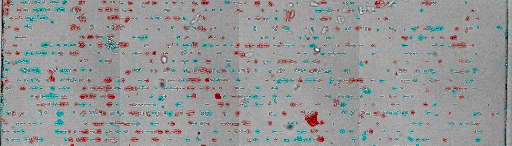

In [53]:
#color the raw image
colored_img = np.subtract(raw_img, filt)

#limit image values to 0 to 255 and compress image data type
colored_img[colored_img<0] = 0
colored_img[colored_img>255] = 255
colored_img = colored_img.astype('uint8')
print(f"the max value of right flow is {np.max(colored_img[...])} while the min value of right flow is {np.min(colored_img[...])}.")
colored_img

### step 3.b: ^that routine to color all frames and save as a .tiff

In [69]:
def color_frame(raw_img, red_img, blue_img, hue_scale_red  = 100, hue_scale_blue = 100):
    #make color filter to subtract from raw image
    raw_img = pims.to_rgb(raw_img)
    width, height, channel_number = raw_img.shape
    filt = np.zeros([width,height,channel_number])
    filt[...,0] = hue_scale_blue*blue_img#take away   red where you want blue
    filt[...,1] = hue_scale_blue*blue_img#take away green where you want blue
    filt[...,1] = hue_scale_red*red_img#take away green where you want red
    filt[...,2] = hue_scale_red*red_img#take away blue where you want red
    
    #color the raw image
    colored_img = np.subtract(raw_img, filt)

    #limit image values to 0 to 255 and compress data type of output image
    colored_img[colored_img<0] = 0
    colored_img[colored_img>255] = 255
    colored_img = colored_img.astype('uint8')
    return colored_img

Frame([[[164, 164, 164],
        [176, 176, 176],
        [156, 181, 181],
        ...,
        [149, 149, 149],
        [146, 146, 146],
        [133, 133, 133]],

       [[175, 175, 175],
        [186, 186, 186],
        [163, 188, 188],
        ...,
        [170, 170, 170],
        [171, 171, 171],
        [148, 148, 148]],

       [[170, 170, 170],
        [158, 183, 183],
        [169, 194, 194],
        ...,
        [179, 179, 179],
        [179, 179, 179],
        [155, 155, 155]],

       ...,

       [[ 56,  85,  85],
        [ 63,  92,  92],
        [130, 159, 159],
        ...,
        [134, 134, 134],
        [138, 138, 138],
        [134, 134, 134]],

       [[ 76, 104, 104],
        [ 64,  93,  93],
        [135, 164, 164],
        ...,
        [127, 127, 127],
        [145, 145, 145],
        [130, 130, 130]],

       [[ 76, 104, 104],
        [ 82, 110, 110],
        [146, 175, 175],
        ...,
        [137, 137, 137],
        [146, 146, 146],
        [144, 144, 144]]], dtype=uint8)
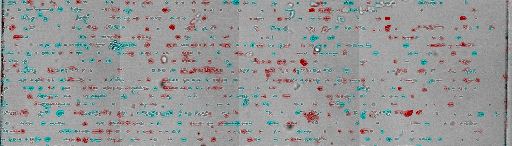

In [70]:
#test the above result for a given frame
frm   = 42
frame = frames[frm]
raw_img      = frame[...,3]
left_flow    = frame[...,0]
right_flow   = frame[...,1]
colored_img  = color_frame(raw_img = raw_img,
                          red_img  = left_flow,
                          blue_img = right_flow)
colored_img

the time averaged frame has shape (492, 1716, 4).


Frame([[[164, 164, 164],
        [176, 176, 176],
        [171, 173, 173],
        ...,
        [149, 149, 149],
        [146, 146, 146],
        [133, 133, 133]],

       [[175, 175, 175],
        [184, 186, 186],
        [178, 180, 180],
        ...,
        [170, 170, 170],
        [171, 171, 171],
        [148, 148, 148]],

       [[170, 170, 170],
        [173, 175, 175],
        [184, 186, 186],
        ...,
        [179, 179, 179],
        [179, 179, 179],
        [155, 155, 155]],

       ...,

       [[ 58,  79,  79],
        [ 65,  86,  86],
        [132, 153, 153],
        ...,
        [134, 134, 134],
        [138, 138, 138],
        [134, 134, 134]],

       [[ 77,  98,  98],
        [ 66,  87,  87],
        [137, 158, 158],
        ...,
        [127, 127, 127],
        [145, 145, 145],
        [130, 130, 130]],

       [[ 77,  98,  98],
        [ 83, 104, 104],
        [148, 169, 169],
        ...,
        [137, 137, 137],
        [146, 146, 146],
        [144, 144, 144]]], dtype=uint8)
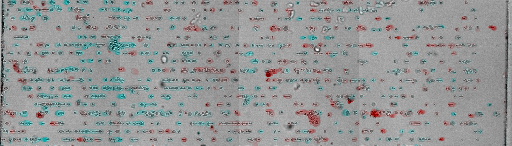

In [71]:
#(optional) time average flow 
navg  = 10 #number of frames to average over
frm   = 42
def average_image_list(img_list):
    img = np.stack(img_list[:], axis=0)
    img = np.mean(img, axis=0)
    return img
frame = frames[frm]
raw_img      = frame[...,3]
time_averaged_frame   = average_image_list(frames[frm-navg:frm])
left_flow    = time_averaged_frame[...,0]
right_flow   = time_averaged_frame[...,1]
colored_img  = color_frame(raw_img = raw_img,
                          red_img  = left_flow,
                          blue_img = right_flow, 
                          hue_scale_red = 130,
                          hue_scale_blue = 130)
print(f"the time averaged frame has shape {time_averaged_frame.shape}.")
colored_img

In [72]:
#define where to save
flow_file_name = save_file_name
os.chdir(os.path.dirname(data_file_name))
colored_file_name = flow_file_name.replace('.tif', '_colored.tiff')
save_params = {'append':'True', 'imagej':False, 'contiguous':True}
print(f"We're going to save in {save_file_name}, which is in {os.getcwd()}.") 

#load the flow data
frames = pims.TiffStack_libtiff(save_file_name)

#number of frames to average over
navg  = 5 

#remove the save file if it already exists
if os.path.exists(colored_file_name):
    os.remove(colored_file_name)

    
#loop over all frames (this could be parallelized)    
print('starting...')
start = time.time()
inputs = range(navg,len(frames))
for frm in inputs:
    frame = frames[frm]
    raw_img      = frame[...,3]
    time_averaged_frame   = average_image_list(frames[frm-navg:frm])
    left_flow    = time_averaged_frame[...,0]
    right_flow   = time_averaged_frame[...,1]
    colored_img  = color_frame(raw_img = raw_img,
                              red_img  = left_flow,
                              blue_img = right_flow, 
                              hue_scale_red = 130,
                              hue_scale_blue = 130)
    tifffile.imsave(colored_file_name, colored_img, colored_img.shape, **save_params)
end = time.time()
print('{} seconds elapsed coloring frames.'.format(np.around(end-start,1)))

We're going to save in pos1234_C0_output.tif, which is in /Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/Python/data/aravind's 1D data.
starting...
52.8 seconds elapsed coloring frames.


### step 3.c: convert the colored frames to a .avi movie

In [77]:
def tiffstack_to_avi(input_file_name, save_dir= None, fps=8):
    '''saves tiffstack found in the local 'path' to save_dir to a similarly named .avi file if save_dir=None.
    fps = frames per second.'''
    path = input_file_name
    if save_dir == None:
        save_dir= path[:path.find(r'.tif')]+'.avi'
    start = time.time()
    boo, cap = cv.imreadmulti(path)
    width = int(cap[0].shape[0])
    height = int(cap[0].shape[1])
    try:
        chnl_no = int(cap[0].shape[2])
    except:
        chnl_no = 0#or 1, not sure
        print('Error: depth shape not given, returning 0')
    # uncompressed YUV 4:2:0 chroma subsampled
    fourcc = cv.VideoWriter_fourcc('I','4','2','0')
    writer = cv.VideoWriter()
    retval = writer.open(save_dir, fourcc, fps, (width, height), 1)
    assert(writer.isOpened())#assert the writer is properly initialized
    for i  in range(len(cap)):
        #TODO: make this step faster by using something like the (missing) cv.GrabFrame command 
        frame = cap[i]
        writer.write(frame)
    writer.release()
    end = time.time()
    print('{} seconds elapsed reading tiffstack and writing video to avi.'.format(np.around(end-start)))
    return True

In [75]:
boo, cap = cv.imreadmulti(colored_file_name)

In [78]:
tiffstack_to_avi(colored_file_name)

1.0 seconds elapsed reading tiffstack and writing video to avi.


True

In [76]:
colored_file_name

'pos1234_C0_output_colored.tiff'

In [79]:
colored_file_name

'pos1234_C0_output_colored.tiff'

In [ ]:
#TODO: test that .avi file opens correctly.

## option c: compute mean chemotactic index with spatial averaging

In [49]:
#Fig. 1 Filenames (Poster Child)
#is the raw flow saved? No
# loaded all the necessaries
dic_dir    = '/Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/Python/data/data_for_poster_child/optical_flow_output/poster_child_frames copy.tif'
#TODO(later): get edges as done above
df_dir     = '/Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/Python/data/data_for_poster_child/poster_child_cluster_trajectory.csv'
#TODO(later): import cluster trajectory as is done above
radial_dir = '/Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/Python/data/data_for_poster_child/optical_flow_output/flow_radial_poster_child.tiff'
radial_results = pims.TiffStack_libtiff(radial_dir) 

In [50]:
def get_mean_ci(i,img_list,r1=100,r2=300):
    '''img_list is a list of preprocessed boolean grayscale images.
    get_mean_ci calculates the mean chemotactic index averaged 
    over cell area in the annulus centered at the centroid. 
    r1 and r2 is the inner/outer diameter of the annulus in microns.
    i is the index of the "before" frame in img_list.  
    DIS dense optical flow is computed from img_list.
    '''
    #calculate dense optical flow
    prv = img_list[i]
    nxt = img_list[i+1]
    flow = of.calc_flow(prv,nxt)
    position = tuple(df.loc[i,['x','y']].values)
    #r_c_mat is the distance from the centroid in microns
    r_hat_mat, r_c_mat = of.get_r_hat_mat(position)
    boo = (r2>r_c_mat) & (r_c_mat>r1)
    #get radial component
    flow_out_x  = np.multiply(flow[...,0],r_hat_mat[...,0])
    flow_out_y  = -np.multiply(flow[...,1],r_hat_mat[...,1])
    flow_out = flow_out_x+flow_out_y

    #get total component
    length = np.sqrt(np.multiply(flow[...,0],flow[...,0])
            +np.multiply(flow[...,1],flow[...,1]))

    #calculate chemotactic index everywhere
    ci = np.divide(flow_out,length)
    ci[np.isnan(ci)]=0
    
    #threshold by speed
    lamda= 1.33
    dt   = 0.5
    speed_thresh = 0/lamda*dt
    boo_speed = length>=speed_thresh
    
    #import cell area phase field channel
    area = radial_results[i][...,-1]
    #multiply chemotactic index by cell area channel
    result = np.multiply(ci,area)
    #average over result[boo]
    ci_avg = np.median(result[(result!=0) & boo & boo_speed])
#     ci_avg = np.mean(result[(result!=0) & boo & boo_speed])
#     ci_avg = result[(result!=0) & boo & boo_speed].mean()
#     ci_total   = np.array(result)[boo].sum()
    #TODO: repeat with normalizing by nonzero elements of ci instead of area
#     ci_num_nonzero = (ci!=0)[boo].sum()
#     area_total = np.array(area)[boo].sum()
    #return mean ci
#     ci_mean = ci_total/area_total
#     ci_mean = ci_total/ci_num_nonzero
    return ci_avg

\begin{eqnarray*}
r_{i} = \text{the distance pixel i is from the centroid}
\end{eqnarray*}

In [51]:
#test function
# get_mean_ci(300)

#DONE: checked that the ci is between -1 and 1
#alternative solution to getting raw radial component before thresholding
# resolve complication of angular thresh by changing of.angthresh
# radial = of.dot(flow,r_hat_mat)
# flow_in, flow_out = of.dot(flow,r_hat_mat)

In [53]:
#wrap all ^that in a function and loop over all frames
r1=100
r2=300
frm_max = len(edges)-1
mci_lst = []
start = time.time()
for i in range(frm_max):
    #actually median ci
    mci = get_mean_ci(i,img_list=edges,r1=r1,r2=r2)
    mci_lst.append(mci)
end   = time.time()
#note: i think the time printing is inaccurate. hmm...
print(f'{np.around(end-start)} seconds elapsed calculating mean chemotactic index.')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


50.0 seconds elapsed calculating mean chemotactic index.


In [54]:
#save results as csv
trialnum = 'poster_child'
save_file_name = f'mean_CI_{trialnum}_r1_{r1}_r2_{r2}.csv'
ef = df.drop(columns=['frm_values','x','y']).loc[df.frame>0]
ef['ci'] = mci_lst
ef.to_csv(save_file_name,index=False)
file_name_df = save_file_name
save_file_name = file_name_df[:-4]+'.png'

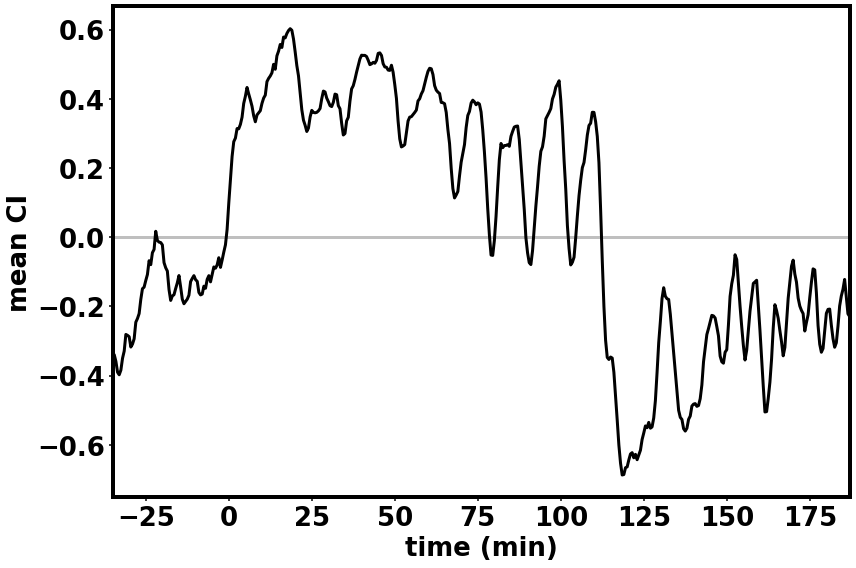

In [56]:
#plot up mean CI and move on, skipper!
text = None
# text = 'PDE1\nadded'

#do you have the right units?
# lamda = 1.33
# dt = .5

fn = file_name_df
xshift=0#+2#70
yshift=0#.8#2#.36
# yval = float(df_sum.query('t==0')[['in','out']].T.max()/df_sum.query('t==0')[['area']].T.max())#+0.001
# yval = ax1.get_ylim()[1]/2
yval = 1#0.2
navg = 5#of.navg#minutes

# save_file_name = fn[:-4]+'_plotted_flow.png'
df_sum = pd.read_csv(fn)
df_sum = df_sum.rolling(navg).mean().copy()
#calculate the relevant data to plot

# fret_values = df_near['fret'].values/df_far['area']#/df_near['fret'].max()
t_values = df_sum['t_onset']+(navg-1)/2

ci_values   = df_sum['ci'].values

#TODO(if needed): consider time average

arrowprops = {'width':3, 'headwidth':12, 'headlength':12, 'color':'black'}
#arrowprops = {"arrowstyle":'->', 'width':0.4}
fontsize = 26
linewidth=3
tmin = t_values.min()
tmax = t_values.max()

#plot results in a single line plot
fig = plt.figure(figsize = (12, 8))#num=None, frameon=True, figsize=(mult*512/mydpi, mult*512/mydpi), dpi=mydpi, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(111)
ax1.plot(t_values, 0*ci_values, c='gray', linewidth=linewidth, alpha=0.5)
ax1.plot(t_values, ci_values, c='black', linewidth=linewidth)

#     ax1.set_title('annulus from {}µm to {}µm'.format(int(np.around(r1)),int(np.around(r2))),fontsize=fontsize)
ax1.set_ylabel('mean CI',fontsize=fontsize, fontweight='bold')
ax1.set_xlabel('time (min)',fontsize=fontsize, fontweight='bold')
ax1.tick_params(labelsize=fontsize, length=4, width=1.5, which='both')
ax1.axis([tmin, tmax,ax1.get_ylim()[0],ax1.get_ylim()[1]])
if text is not None:
    ax1.annotate(text,(0,yval), 
                 xytext = (0+xshift,yval+yshift),
                 xycoords='data', 
                 fontsize=fontsize,
                arrowprops=arrowprops,
                horizontalalignment='center', fontweight='bold')

ax = ax1
for tick in ax.xaxis.get_major_ticks():
#     tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
#     tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
plt.rc('axes', linewidth=4)
# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# color = 'tab:gray'
# ax2.set_ylabel('fret intensity per cell area (A.U.)', color=color, fontsize=fontsize)  # we already handled the x-label with ax1
# ax2.plot(t_values, fret_values, c=color, linewidth=linewidth, alpha=0.5)
# ax2.tick_params(axis='y', labelsize=fontsize, length=4, width=1.5, which='both')

plt.tight_layout()    
fig.savefig(save_file_name, dpi=300)

## option d: measure the cross correlation between signals.
- working method came from : http://localhost:8888/notebooks/nb/Quantization%20of%20Variance%20of%20Grayscale%20in%20the%20Poster%20Child.ipynb
     - current example: the CC function btwn fluor. intens. and inward cell motion

In [516]:
# # not sustainable or needed here
# save_folder = nb_dir+"/../../Richa's High Time Resolution Experiment/Data"
# os.chdir(save_folder)
# #not a sustainable import
# from optical_flow_copy import *
# import cv2

In [517]:
path = '/Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/Python/data/data_for_dispersing_051719Pos4/results_r1_60_r2_120_navg_1_051719Pos4_aio.csv'
# path = '/Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/Python/data/data_for_dispersing_051719Pos4/optical_flow_results/results_r1_60_r2_120_051719_pos4.csv'
data_dir = path[:path.find('/results')]
os.chdir(data_dir)
file_name_df = path[path.find('/results')+1:]

save_file_name = fn[:-4]+'_plotted_flow.png'
print(file_name_df)
# trialnum = 'poster_child'
trialnum = '051719_pos4'
t_onset = 116
# of = OpticalFlowClient(dt=0.5)
# of = OpticalFlowClient(dt=.5)

# file_name_df = f'results_r1_{60}_r2_{120}_navg_{3}_{trialnum}.csv'
fn = file_name_df

df = pd.read_csv(file_name_df)

results_r1_60_r2_120_navg_1_051719Pos4_aio.csv


the time delay from region A to region B is 30 seconds.


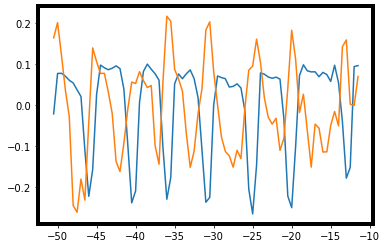

In [518]:
#moving average of inward cell motion signal
navg = 2
df['main'] = df['in'].rolling(navg).mean()
t_shift = +0.5*2 #shift so the CC function gives the apparent delay of ~30 seconds

tmin = -50#40#-50
tmax = -10#70#-20

boot_B = (df.t>tmin-t_shift) & (df.t<tmax-t_shift)
signal_B = df.loc[boot_B, 'main'].values
t_values = df.loc[boot_B, 't'].values

boot_A = (df_m.t_offset>tmin) & (df_m.t_offset<tmax)
signal_A = df_m.loc[boot_A, 'imf'].values

#norm
A0 = np.mean(signal_A)
signal_A = np.log(signal_A/A0)
B0 = np.mean(signal_B)
signal_B = np.log(signal_B/B0)

#detrend 
signal_A = signal.detrend(signal_A)
signal_B = signal.detrend(signal_B)

#formally normalize
signal_A /= np.linalg.norm(signal_A)
signal_B /= np.linalg.norm(signal_B)

ccAB = signal.correlate(signal_B, signal_A, method='fft')#, mode='same')

ln = ccAB.shape[0]
dt = float(1/2)
tau_values = np.arange(-ln/2,ln/2,1)*dt+dt/2
cor_values = ccAB.copy()
delay = tau_values[np.argmin(ccAB)]*60
# delay = tau_values[np.argmax(ccAB)]*60
print(f'the time delay from region A to region B is {delay:.0f} seconds.')

plt.plot(t_values, signal_A)
plt.plot(t_values, signal_B)
plt.show()

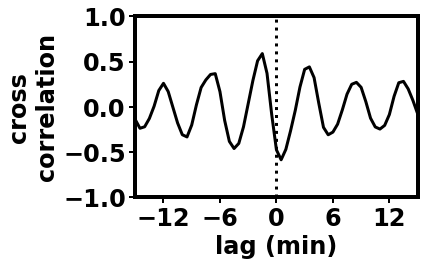

In [519]:
#format this plot to make a nice cc funciton for WJ
# fig = plt.figure(figsize = (8, 6))
saveQ = True
fig, axs = plt.subplots(1, 1, figsize=(6, 3.8))

fontsize  = 24
linewidth = 3

# #plot of cross correlation function
ax2 = axs
ax2.plot(tau_values, cor_values, c='k', lw=linewidth)

# #format
ax2.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.set_ylabel('cross\ncorrelation',fontsize=fontsize, fontweight='bold')
ax2.set_xlabel('lag (min)',fontsize=fontsize, fontweight='bold')
ax2.tick_params(labelsize=fontsize, length=6, width=2, which='both')
ax2.axis([-15, 15, -1, 1])
ax2.set_yticks([-1,-0.5,0,0.5,1])
# ax2.set_xticks([-15,-10,-5,0,5,10, 15])
ax2.set_xticks([-12,-6,0,6,12])

# #make ticks bold
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')

yv = np.linspace(-1,1.,20)
xv =  + 0.*yv
ax2.plot(xv,yv, 'k:', lw=linewidth)   

fig.tight_layout()#h_pad=3.0)
if not saveQ:
    plt.show()    
else:
    plt.tight_layout() 
    save_dir  = f'{nb_dir}/../data'
#     os.chdir(save_dir)
    plt.savefig('fig_2g_cc_fret_to_inward_motion_before.png', dpi=400)





the time delay from region A to region B is 60 seconds.


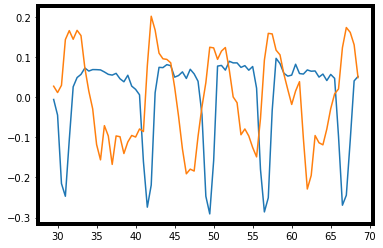

In [520]:
#moving average of inward cell motion signal
navg = 2
df['main'] = df['in'].rolling(navg).mean()
# t_shift = +0.5*2 #shift so the CC function gives the apparent delay of ~30 seconds

tmin = 30#-50#-50
tmax = 70#-10#-20

boot_B = (df.t>tmin-t_shift) & (df.t<tmax-t_shift)
signal_B = df.loc[boot_B, 'main'].values/df.loc[boot_B, 'area'].values
t_values = df.loc[boot_B, 't'].values

boot_A = (df_m.t_offset>tmin) & (df_m.t_offset<tmax)
signal_A = df_m.loc[boot_A, 'imf'].values

#norm
A0 = np.mean(signal_A)
signal_A = np.log(signal_A/A0)
B0 = np.mean(signal_B)
signal_B = np.log(signal_B/B0)

#detrend 
signal_A = signal.detrend(signal_A)
signal_B = signal.detrend(signal_B)

#formally normalize
signal_A /= np.linalg.norm(signal_A)
signal_B /= np.linalg.norm(signal_B)

ccAB = signal.correlate(signal_B, signal_A, method='fft')#, mode='same')

ln = ccAB.shape[0]
dt = float(1/2)
tau_values = np.arange(-ln/2,ln/2,1)*dt+dt/2
cor_values = ccAB.copy()
delay = tau_values[np.argmin(ccAB)]*60
# delay = tau_values[np.argmax(ccAB)]*60
print(f'the time delay from region A to region B is {delay:.0f} seconds.')

plt.plot(t_values, signal_A)
plt.plot(t_values, signal_B)
plt.show()

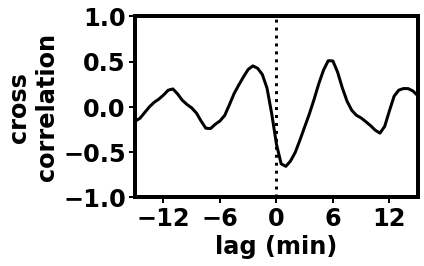

In [521]:
#format this plot to make a nice cc funciton for WJ
# fig = plt.figure(figsize = (8, 6))
saveQ = True
fig, axs = plt.subplots(1, 1, figsize=(6, 3.8))

fontsize  = 24
linewidth = 3

# #plot of cross correlation function
ax2 = axs
ax2.plot(tau_values, cor_values, c='k', lw=linewidth)

# #format
ax2.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.set_ylabel('cross\ncorrelation',fontsize=fontsize, fontweight='bold')
ax2.set_xlabel('lag (min)',fontsize=fontsize, fontweight='bold')
ax2.tick_params(labelsize=fontsize, length=6, width=2, which='both')
ax2.axis([-15, 15, -1, 1])
ax2.set_yticks([-1,-0.5,0,0.5,1])
# ax2.set_xticks([-15,-10,-5,0,5,10, 15])
ax2.set_xticks([-12,-6,0,6,12])

# #make ticks bold
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')

yv = np.linspace(-1,1.,20)
xv =  + 0.*yv
ax2.plot(xv,yv, 'k:', lw=linewidth)   

fig.tight_layout()#h_pad=3.0)
if not saveQ:
    plt.show()    
else:
    plt.tight_layout() 
    save_dir  = f'{nb_dir}/../data'
#     os.chdir(save_dir)
    plt.savefig('fig_2g_cc_fret_to_inward_motion_after.png', dpi=400)





In [450]:
save_dir

"/Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/Richa's High Time Resolution Experiment/Data/../data"

In [2]:
#TODO: find the method to developed that gets peaks for the recent cross correlation effort (on Fig. 2G???)

### (ignore) 
(fluorescence DTT in vitro work) naive/failed attempt to get nice spikes in fret signal

In [43]:
def get_r_hat_mat(width, height, position):
    '''get_r_hat_mat([x_coord,y_coord])--> r_hat_mat, r_c_mat
    returns texture width xy channels populated by the unit vector pointing radially away from position.''' 
    #make a texture of the r_hat outward from the cluster
    xc,yc = tuple(position)
    y_mat = np.array([x for x in range(width) for y in range(height)]).reshape(width,height)
    x_mat = np.array([y for x in range(width) for y in range(height)]).reshape(width,height)
    dx_mat = x_mat - xc
    dy_mat = y_mat - yc
    r_c_mat  = np.sqrt(dx_mat**2+dy_mat**2)
    boo      = (r_c_mat>=1)
    # r_hat_mat   = dr_mat
    r_hat_mat_x = np.divide(dx_mat,r_c_mat, where=boo)
    r_hat_mat_y = np.divide(-dy_mat,r_c_mat, where=boo)#flip y axis
    r_hat_mat   = np.stack([r_hat_mat_x,r_hat_mat_y], axis=2)
    return r_hat_mat, r_c_mat   

In [44]:
import skimage.filters as filters

In [17]:
from scipy.ndimage import maximum_filter

In [10]:
#fig. 5 data (DTT experiment)
dic_dir = '/Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/experiment_with_DTT/4X/122019-2/Capture 1 - Position 12_XY1576876376_Z0_T000_C0.tif'
fret_dir = '/Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/experiment_with_DTT/4X/122019-2/Capture 1 - Position 12_XY1576876376_Z0_T000_C1.tif'
data_dir = '/Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/experiment_with_DTT/4X/122019-2/'
os.chdir(data_dir)
file_name_radial = 'flow_radial_122019-2_pos12_top_right.tiff'
cluster_dir = "cluster_122019-2_pos12_top_right_cubic_spline.csv"

# #dtt experiment
# dt = 1 #minute between each frame. verified.
# lamda = 3.7313 #microns per pixel. verified.
# dic_dir  = '/Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/experiment_with_DTT/4X/122019-2/Capture 1 - Position 12_XY1576876376_Z0_T000_C0.tif'
# fret_dir = '/Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/experiment_with_DTT/4X/122019-2/Capture 1 - Position 12_XY1576876376_Z0_T000_C1.tif'
# cluster_dir = '/Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/experiment_with_DTT/4X/122019/122019_pos1/cluster_122019_pos1_middle_cubic_spline.csv'
# df_dir = cluster_dir

#load raw dic data
os.chdir(dic_dir[:len(dic_dir)-dic_dir[::-1].find('/')])
@pims.pipeline
def gray(image):
    return np.uint8(image[:, :, 1])  # Take just the green channel
frames= pims.TiffStack_libtiff(dic_dir)

#load raw fret data
@pims.pipeline
def max_filter(image):
    return np.uint8(maximum(image, disk(3)))  #rad=3 pixel filter radius
fret_frames_unfiltered= pims.TiffStack_libtiff(fret_dir)
# fret_frames_unfiltered = pims.TiffStack(fret_dir)
#caution: this line is not equivalent to below: fret_frames = pims.TiffStack(fret_dir, process_func = max_filter)
#the following is slow but appears necessary to get nice 
# fret_frames = [max_filter(img) for img in fret_frames]#TODO: set verbose to false.  it prints a lot when there's a large number of bins
fret_frames = []
for img in fret_frames_unfiltered:
    fret_frames.append(img)
#     fret_frames.append(max_filter(img))
    #TODO: set verbose to false.  it prints a lot when there's a large number of bins

In [18]:
# KEEP IT SIMPLE STUPID! filters.max()
#TODO: look for functions I put into .py files that iterate the updated method for getting nice spikes
#TODO: it's just a fucking max filter.  Just redo it here and apply at ranges closer than 10µm!

In [19]:
frm = 100
img = fret_frames[frm]

Frame([[1070, 1070, 1003, ..., 1089, 1089,  996],
       [1070, 1070, 1008, ..., 1089, 1089, 1020],
       [1037, 1037, 1008, ..., 1026, 1036, 1036],
       ...,
       [1100, 1100, 1045, ..., 1022, 1022, 1023],
       [1059, 1059, 1121, ..., 1014, 1003, 1006],
       [1059, 1059, 1121, ..., 1004, 1005, 1006]], dtype=uint16)
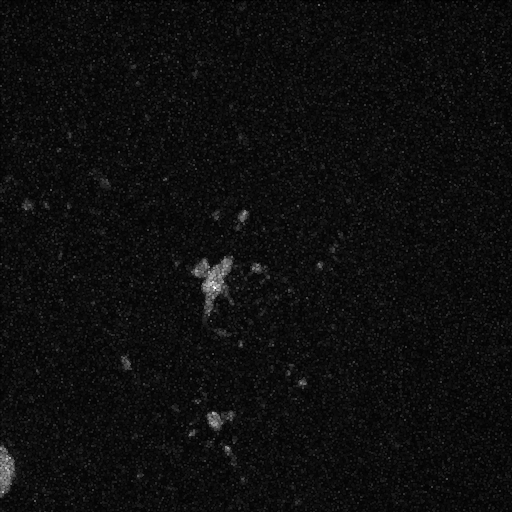

<Figure size 432x432 with 0 Axes>

In [38]:
out_img = maximum_filter(img, footprint=np.ones([2,2]) )
plt.figure(figsize=(6,6))
# plt.imshow(out_img , cmap = 'gray')
pims.Frame(out_img)

Frame([[1070, 1003,  994, ..., 1089,  995,  996],
       [1037,  993, 1008, ...,  995, 1000, 1020],
       [ 993,  999,  993, ...,  985, 1036,  991],
       ...,
       [1008,  997, 1029, ..., 1003, 1002,  986],
       [1059, 1002, 1121, ..., 1000, 1002, 1006],
       [1026, 1014, 1053, ..., 1002, 1005,  992]], dtype=uint16)
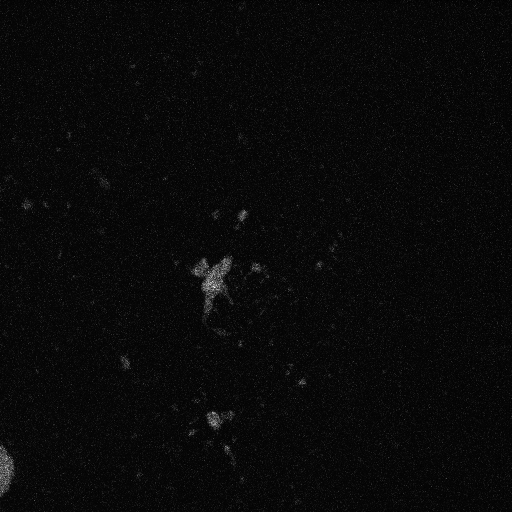

In [39]:
img

In [57]:
position=(100,256)
#this is the mean max-filtered fret intensity sampled closer than 10 microns of position
r_hat_mat, r_c_mat    = get_r_hat_mat(width=512, height=512, position=position)
boo = r_c_mat<10/lamda
np.mean(np.array(out_img[boo].flatten()))


In [62]:
#TODO: prepare the time series of cluster position arguments
df = pd.read_csv(cluster_dir)
# position=(100,256)

In [73]:
position_list = list(df[['x','y']].values)

In [84]:
signal_list = []
for position in position_list:
    #this is the mean max-filtered fret intensity sampled closer than 10 microns of position
    r_hat_mat, r_c_mat    = get_r_hat_mat(width=512, height=512, position=position)
    boo = r_c_mat<20/lamda
    val = np.mean(np.array(out_img[boo].flatten()))
    signal_list.append(val)

In [85]:
df_fret = pd.DataFrame({'frame':df.frame.values, 'signal':signal_list})

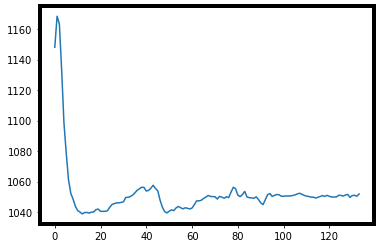

In [86]:
plt.plot(df_fret.signal)

# some notes

how I got the signals to look spiky in the past using max filtration

source:
- 'Measuring Phase Lag from Cluster to Neighbors.ipynb'
- http://localhost:8888/notebooks/nb/Measuring%20Phase%20Lag%20from%20Cluster%20to%20Neighbors.ipynb

destination:
- http://localhost:8888/notebooks/nb/Responses%20to%20Reviewers.ipynb#observe-apparent-peak-height-versus-radial-distance-for
- result: sharp optical flow highlighting in ipython for fig. 6ab (TODO: fig. 5ab)

# save highlighted .tiffstack from flow results
- code sampled from local notebook, dense_optical_flow_analysis_of_dispersal.ipynb

In [147]:
#file_name_space for trial 11222017_pos_3
workspace_dir = '/Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/Responses to Reviewers/optical_flow_results/'
os.chdir(workspace_dir)
flow_dir = 'flow_radial_11222017_pos_3.tiff'
dic_dir  = "Capture 2 - Position 3 - 1.crop_XY1511368074_Z0_T000_C0.tif"
df_dir = '11222017_pos_3_manual_knots.csv'
save_file_name = '11222017_pos_3_highlighted.tiff'
dt = 0.25
width = 307
height = 440

In [148]:
#load data
of = OpticalFlowClient(dt=dt,height=height,width=width)
dic_frames = of.load_tiff_stack(dic_dir)
flow_frames = of.load_tiff_stack(flow_dir)
df = pd.read_csv(df_dir)
# assert(len(dic_frames)==len(flow_frames)+1)
# assert(len(flow_frames)+1==len(fret_frames))
print(len(flow_frames))
print(len(dic_frames))

513
515


In [190]:
def average_flow(flow_frames, frm, navg):
    mfi = flow_frames[frm][...,0]
    mfo = flow_frames[frm][...,1]

    #average flow_frames explicitely
    for t_shift in range(1, navg):
        frm2 = frm - t_shift
        mfi += flow_frames[frm2][...,0]
        mfo += flow_frames[frm2][...,1]
    mfi /= navg
    mfo /= navg
    return mfi, mfo

In [191]:
def remove_overlap(mfi,mfo):
    '''remove any overlap between the mean flow inward/outward.'''
    tmp_in = np.array(mfi)
    tmp_out = np.array(mfo)
    boo_in = tmp_in>0
    boo_out = tmp_in>0

    #subtract opposing flows
    tmp_in[boo_in] -= mfo[boo_in]
    tmp_out[boo_out] -= mfi[boo_out]

    #set the minimum inward/outward flow to zero
    tmp_in  = np.maximum(tmp_in ,0.)
    tmp_out = np.maximum(tmp_out,0.)

    return tmp_in, tmp_out

In [211]:
def highlight_single_frame(frm, navg, inward_color_scale = 1., outward_color_scale = 1.):
    '''highlight a single frame'''
    x_coord,y_coord = df.loc[df.frame==frm][['x','y']].values.T
    r_hat_mat, r_c_mat = of.get_r_hat_mat([x_coord,y_coord])

    background_frame = dic_frames[frm]
    
    #simplest case: no time averaging, which looks flashy/messy.
    #     mfi = flow_frames[frm][...,0]
    #     mfo = flow_frames[frm][...,1]
    
    #average flow_frames explicitely
    mfi, mfo = average_flow(flow_frames, frm, navg)
    mfi, mfo = remove_overlap(mfi,mfo)
    
    #adjust the color saturation
    mfi *= inward_color_scale
    mfo *= outward_color_scale
    
    hf  = of.highlight_flow(frm=frm, background_frame=background_frame, df=df, mfi=mfi, mfo=mfo, r_c_mat=r_c_mat)
    return hf

In [192]:
#some test cases that passed for 11222017_pos_3
# frm = 27
# hf = highlight_single_frame(frm, navg=20, inward_color_scale = 3., outward_color_scale = 3.)
# hf

# navg = 20
# frm = 7
# mfi, mfo = average_flow(flow_frames, frm, navg)
# mfi, mfo = remove_overlap(mfi,mfo)

# assert(np.min(tmp_in)>=0)
# assert(np.min(tmp_out)>=0)

In [208]:
#get a list of highlighted frames averaged over the previous navg frames
navg=20
hf_lst = []
for frm in range(1+navg,len(flow_frames)):
    hf = highlight_single_frame(frm, navg=navg, inward_color_scale = 3., outward_color_scale = 3.)
    hf_lst.append(hf)

In [210]:
#save the list of highlighted frames, hf_lst, as a .tiff
save_params = {'append':'True', 'imagej':False, 'contiguous':True}
for hf in hf_lst:
    img = hf.astype('uint8')
    tifffile.imsave(save_file_name, img, img.shape, **save_params)